# Friedman example with different values of $\alpha$ and $m$

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
from pymc_bart.pgbart import compute_prior_probability

In [2]:
%config Completer.use_jedi = False
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

## Data generation

In [3]:
X = rng.uniform(low=0, high=1.0, size=(100, 10))
f_x = (
    10 * np.sin(np.pi * X[:, 0] * X[:, 1])
    + 20 * (X[:, 2] - 0.5) ** 2
    + 10 * X[:, 3]
    + 5 * X[:, 4]
)
Y = rng.normal(f_x, 1)

In [4]:
trees = [10, 20, 50, 100, 200]
alphas = [0.1, 0.25, 0.5]
idatas_at = {
    "10": {"0.1": {}, "0.25": {}, "0.5": {}},
    "20": {"0.1": {}, "0.25": {}, "0.5": {}},
    "50": {"0.1": {}, "0.25": {}, "0.5": {}},
    "100": {"0.1": {}, "0.25": {}, "0.5": {}},
    "200": {"0.1": {}, "0.25": {}, "0.5": {}},
}

In [ ]:
for m in trees:
    for alpha in alphas:
        with pm.Model() as model:
            μ = pmb.BART("μ", X, Y, m=m, alpha=alpha)
            σ = pm.HalfNormal("σ", 1)
            y = pm.Normal("y", μ, σ, observed=Y)
            idata = pm.sample(chains=4, random_seed=RANDOM_SEED)
            idatas_at[str(m)][str(alpha)] = idata

Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.8864, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
The acceptance probability does not match the target. It is 0.9014, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.
The acceptance probability does not match the target. It is 0.8809, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9061, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9027, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 146 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 146 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 183 seconds.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 287 seconds.
The acceptance probability does not match the target. It is 0.6624, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 3 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


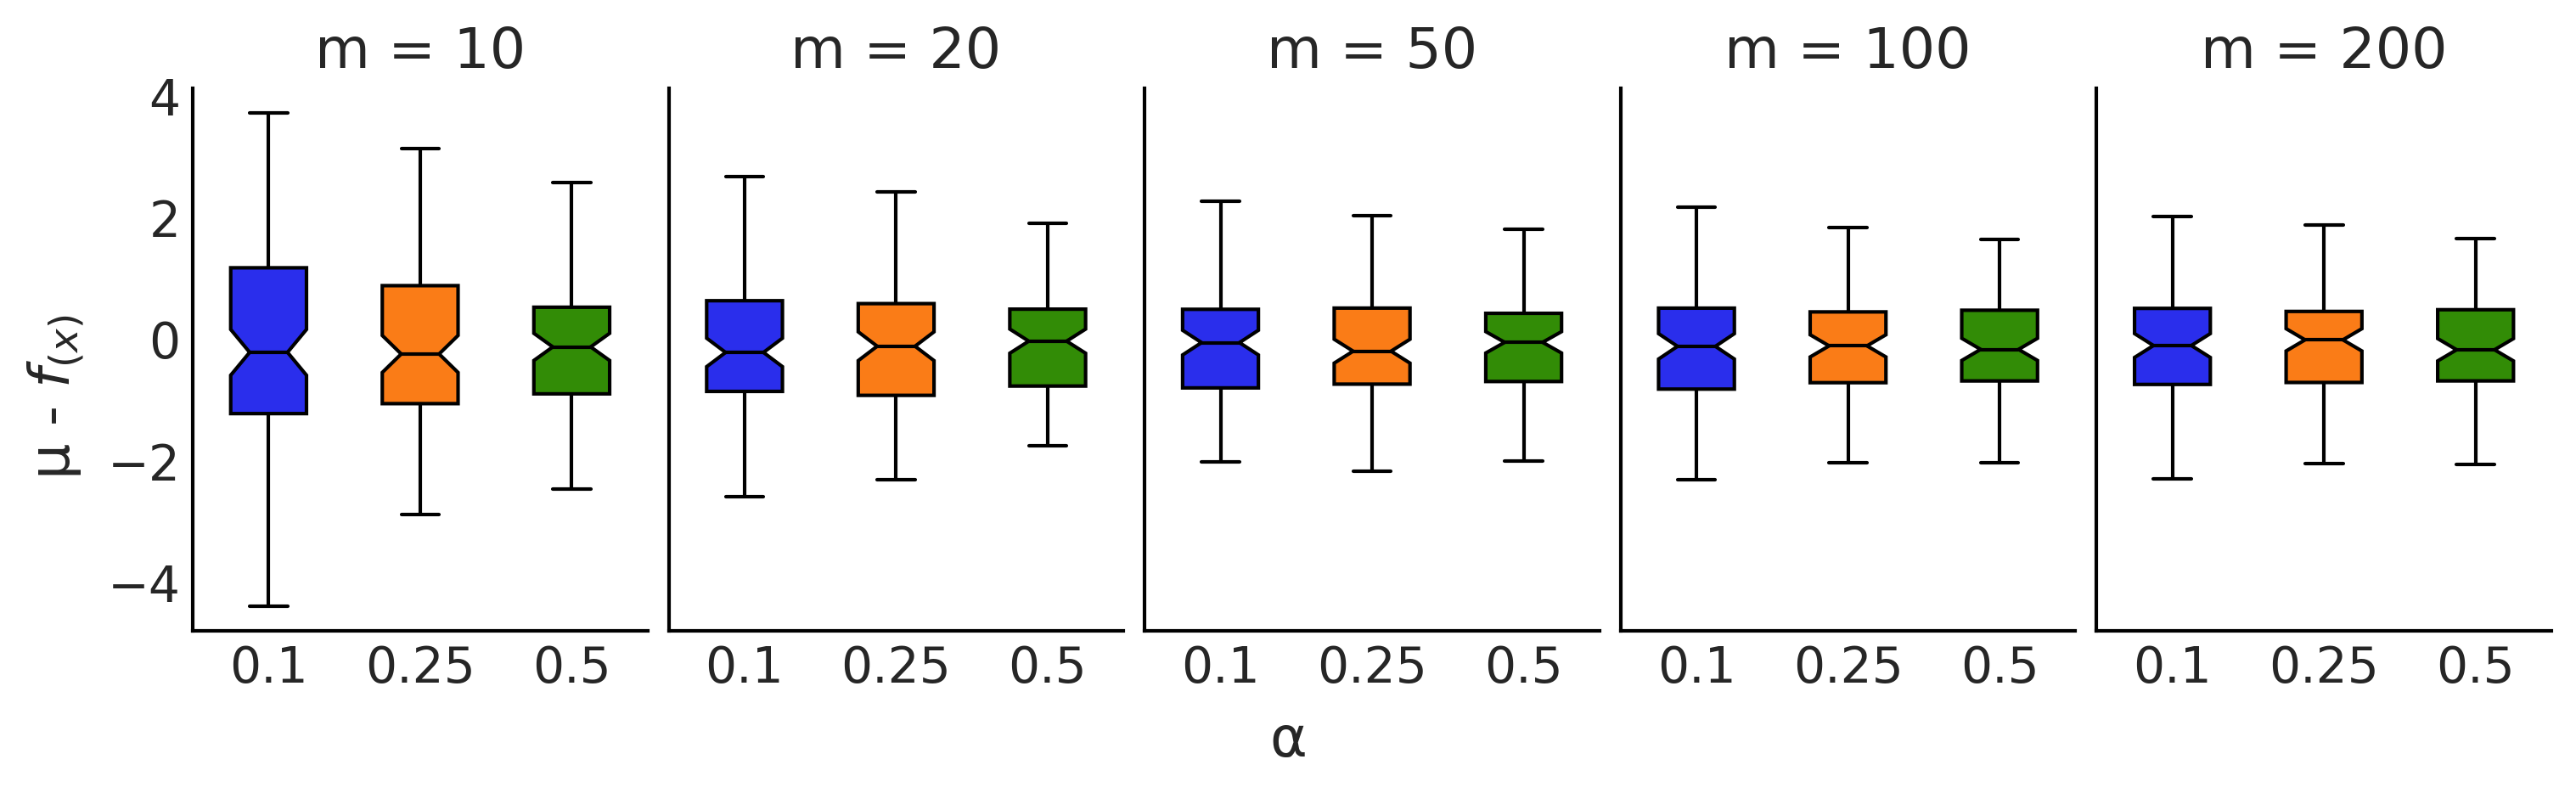

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3), sharey=True)

axes = axes.ravel()

for m, ax in zip(trees, axes):
    means = [
        idatas_at[str(m)][str(alpha)]["posterior"]["μ"].mean(("chain", "draw")) - f_x
        for alpha in alphas
    ]
    box = ax.boxplot(
        means,
        notch=True,
        patch_artist=True,
        widths=0.5,
        labels=alphas,
        showfliers=False,
        medianprops=dict(color="k"),
    )
    for patch, color in zip(box["boxes"], ["C0", "C1", "C2", "C3"]):
        patch.set_facecolor(color)
        ax.set_title(f"m = {m}")

fig.supxlabel(r"α", fontsize=16)
fig.supylabel(r"μ - $f_{(x)}$", fontsize=16)

plt.savefig("boxplots_friedman_i2.png")

## PSIS-LOO-CV

In [8]:
model_compare = az.compare(
    {
        "m10": idatas_at["10"]["0.25"],
        "m20": idatas_at["20"]["0.25"],
        "m50": idatas_at["50"]["0.25"],
        "m100": idatas_at["100"]["0.25"],
        "m200": idatas_at["200"]["0.25"],
    }
)

/home/pablo/Programas/arviz/arviz/stats/stats.py:1047: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/pablo/Programas/arviz/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/pablo/Programas/arviz/arviz/stats/stats.py:1047: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/pablo/Programas/arviz/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because 

In [9]:
model_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m200,0,-160.854699,45.216193,0.000000,1.000000e+00,7.088681,0.000000,True,log
m100,1,-177.382057,42.736913,16.527358,7.689210e-11,7.512110,2.076922,True,log
m50,2,-196.389863,44.914032,35.535164,4.398332e-11,6.987294,2.780504,True,log
m20,3,-218.782005,41.909569,57.927306,1.692585e-11,6.827602,4.783302,True,log
m10,4,-235.324057,39.903157,74.469358,0.000000e+00,6.362135,5.425236,True,log


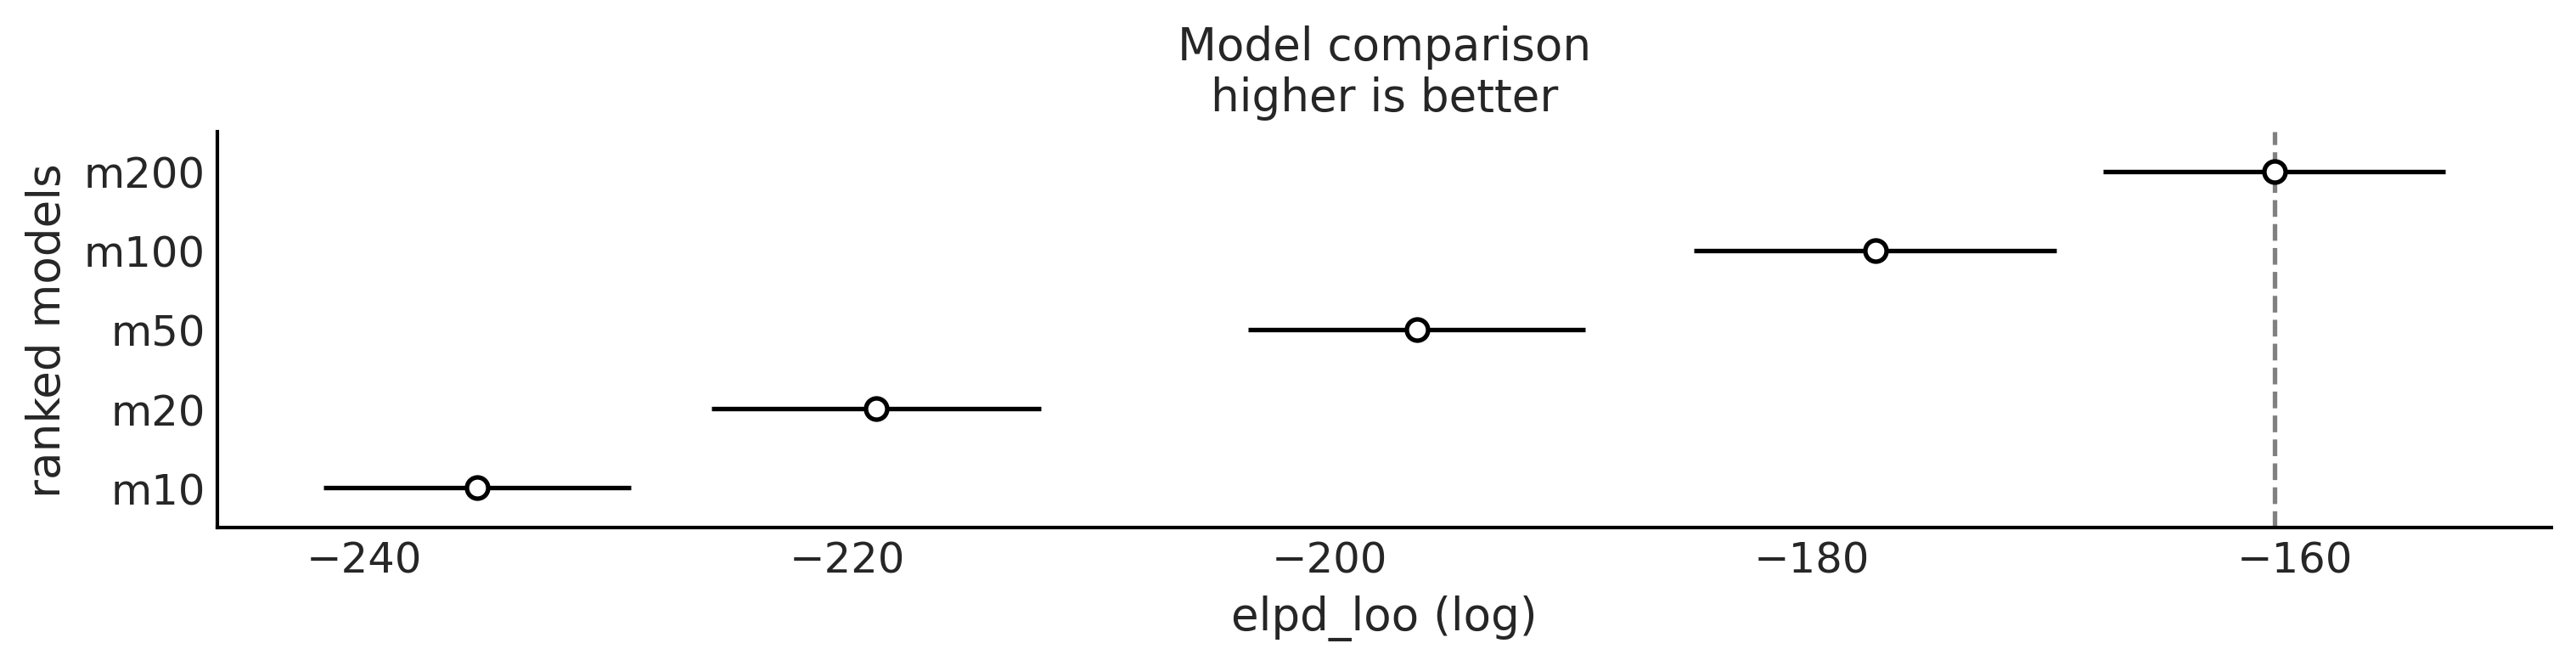

In [10]:
ax = az.plot_compare(
    model_compare,
    plot_ic_diff=False,
    insample_dev=False,
    figsize=(10, 2.5),
    legend=False,
)

plt.savefig("loo_friedman_i2.png")

## Tree extraction  

In [11]:
trees_length = {
    "10": {"0.1": {}, "0.25": {}, "0.5": {}},
    "20": {"0.1": {}, "0.25": {}, "0.5": {}},
    "50": {"0.1": {}, "0.25": {}, "0.5": {}},
    "100": {"0.1": {}, "0.25": {}, "0.5": {}},
    "200": {"0.1": {}, "0.25": {}, "0.5": {}},
}

In [12]:
for m in trees:
    for alpha in alphas:
        tmp_list = []
        idata = idatas_at[f"{m}"][f"{alpha}"].sample_stats.bart_trees
        for chain in idata:
            for sample in chain:
                for tree in sample:
                    index = max(tree.item().tree_structure.keys())
                    tmp_list.append(pmb.tree.BaseNode(index).depth)
        trees_length[f"{m}"][f"{alpha}"] = pd.Series(tmp_list)

In [13]:
# Trees' depth probabilities based on alpha values
prob_alphas = []
for alpha in alphas:
    q = compute_prior_probability(alpha)
    p = 1 - np.array(q)
    p = p / p.sum()
    prob_alphas.append(p)

### Frequency of trees depths

In [14]:
colors = ["C0", "C1", "C2"]
wd = 0.33
wd_lst = [0, wd, wd * 2]

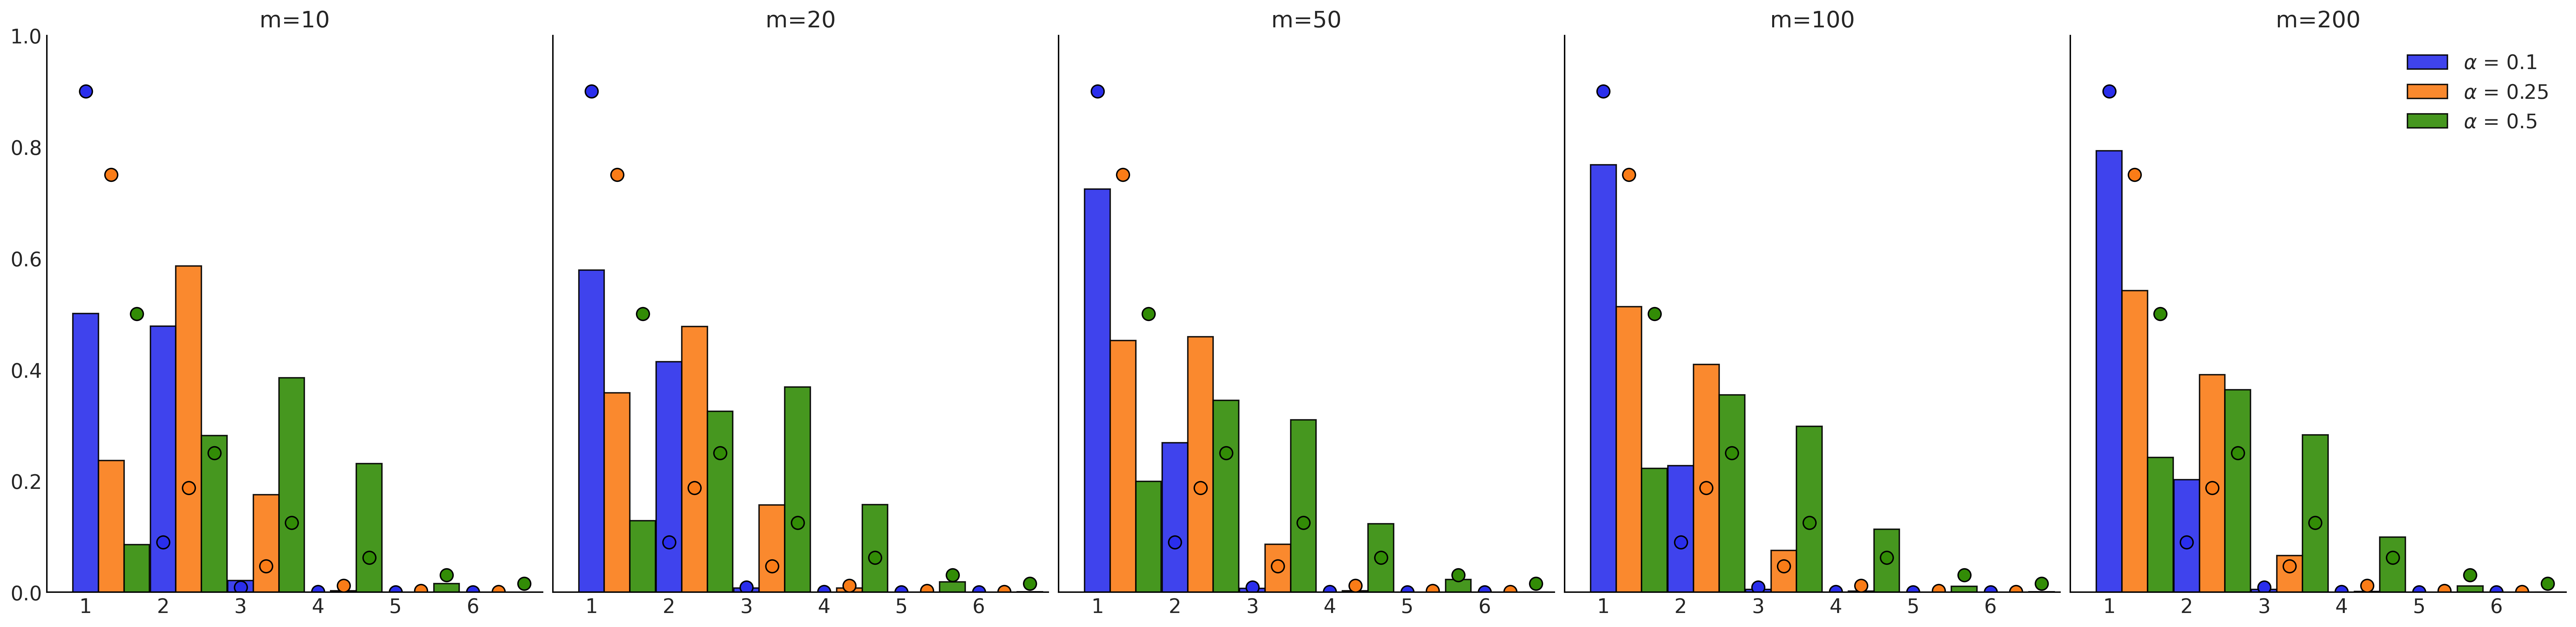

In [15]:
# All frequencies in one plot
fig, axes = plt.subplots(1, 5, figsize=(25, 6), sharey=True)

for m, ax in zip(trees, axes.ravel()):
    for i in range(0, len(alphas)):
        # Trees Depth Frequencies
        frequency = (
            trees_length[f"{m}"][f"{alphas[i]}"]
            .value_counts(normalize=True)
            .sort_index(ascending=True)
        )
        ax.bar(
            frequency.index + wd_lst[i],
            frequency.values,
            color=colors[i],
            width=wd,
            edgecolor="k",
            alpha=0.9,
            label=rf"$\alpha$ = {alphas[i]}",
        )
        # Probabilities
        x = np.array(range(1, len(prob_alphas[i]) + 1)) + wd_lst[i]
        ax.scatter(
            x,
            prob_alphas[i],
            facecolor=colors[i],
            edgecolor="k",
            marker="o",
            s=80,
            zorder=2,
        )

    major_ticks = np.arange(0, 7, 1)
    ax.set_xticks(major_ticks)
    ax.set_ylim(0, 1)
    ax.set_xlim(0.5, 6.9)
    ax.set_title(f"m={m}")
    if m == 200:
        ax.legend()

plt.savefig("friedman_i2_hist.png");